In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
import torch.nn as nn
import torchvision
import torch
from torch import optim
import time
# vgg默认图片输入大小为224*224*3，要用SGD

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
data_root = './autodl-tmp/cifar-10'
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)
data_train = CIFAR10(data_root,
                   train=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(cifar10_mean, cifar10_std)]))
data_test = CIFAR10(data_root,
                  train=False,
                  transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(cifar10_mean, cifar10_std)]))

In [3]:
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=256, num_workers=8)

In [4]:
net = torchvision.models.vgg16(pretrained=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.001)  #2e-3会立马收敛
# 动态更新学习率------每隔step_size : lr = lr * gamma
schedule = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, last_epoch=-1)

In [5]:
len(data_test)

10000

In [6]:
def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    total_correct = 0
    for i, (images, labels) in enumerate(data_train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()
        # if i % 10 == 0:
            # print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))
        loss.backward()
        optimizer.step()
    # 每一轮结束输出一下当前的学习率 lr
    lr_1 = optimizer.param_groups[0]['lr']
    print("learn_rate:%.15f" % lr_1)
    schedule.step()
    avg_loss = sum(loss_list) / len(loss_list)
    acc = float(total_correct) / len(data_train)
    print('Train Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [7]:
def test():
    net.eval()
    batch_list = []
    with torch.no_grad():
        total_correct = 0
        avg_loss = 0.0
        for i, (images, labels) in enumerate(data_test_loader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            avg_loss += criterion(output, labels).sum()
            pred = output.detach().max(1)[1]
            total_correct += pred.eq(labels.view_as(pred)).sum()
            batch_list.append(i+1)

    avg_loss /= batch_list[-1]
    avg_loss = avg_loss.detach().cpu().item()
    acc = float(total_correct) / len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [8]:
def train_and_test(epoch):
    print('training...')
    acc, loss = train(epoch)
    val_acc, val_loss = test()
    return acc, loss, val_acc, val_loss

In [9]:
epoch = 100
acc, loss, val_acc, val_loss = [], [], [], []

start = time.time()
for e in range(epoch):
    a, b, c, d = train_and_test(e)
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)
    print(f'lenet_epoch={e} test_acc={c:0.3f}')
    if e % 10 == 0:
        torch.save(net.state_dict(), f'autodl-tmp/save_model/cifar/vgg16/re_epoch={e}_test_acc={c:0.3f}.pth')
end = time.time()
# 计算并打印输出你的训练时间
print("total time:{}".format(end - start))

training...
learn_rate:0.001000000000000
Train Avg. Loss: 3.060241, Accuracy: 0.097980
Test Avg. Loss: 2.300638, Accuracy: 0.108000
lenet_epoch=0 test_acc=0.108
training...
learn_rate:0.001000000000000
Train Avg. Loss: 2.217423, Accuracy: 0.155260
Test Avg. Loss: 2.008312, Accuracy: 0.250800
lenet_epoch=1 test_acc=0.251
training...
learn_rate:0.001000000000000
Train Avg. Loss: 1.947786, Accuracy: 0.236540
Test Avg. Loss: 1.784221, Accuracy: 0.319400
lenet_epoch=2 test_acc=0.319
training...
learn_rate:0.001000000000000
Train Avg. Loss: 1.774159, Accuracy: 0.319420
Test Avg. Loss: 1.647196, Accuracy: 0.359600
lenet_epoch=3 test_acc=0.360
training...
learn_rate:0.001000000000000
Train Avg. Loss: 1.665692, Accuracy: 0.362880
Test Avg. Loss: 1.689205, Accuracy: 0.359400
lenet_epoch=4 test_acc=0.359
training...
learn_rate:0.001000000000000
Train Avg. Loss: 1.555470, Accuracy: 0.406380
Test Avg. Loss: 1.457444, Accuracy: 0.445300
lenet_epoch=5 test_acc=0.445
training...
learn_rate:0.001000000

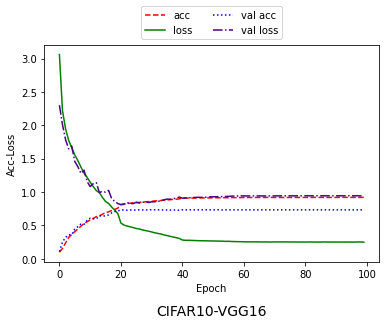

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(epoch)
plt.plot(x, acc, color='red', linestyle='--', label="acc")
plt.plot(x, loss, color='green', label="loss")
plt.plot(x, val_acc, color='blue', linestyle='dotted', label="val acc")
plt.plot(x, val_loss, color='indigo', linestyle='dashdot', label="val loss")
plt.title('CIFAR10-VGG16', fontsize=14, y=-0.27)
plt.xlabel('Epoch')
plt.ylabel('Acc-Loss')
plt.xticks(ticks=[0,20,40,60,80,100])
# 添加图例
plt.legend(loc='center',bbox_to_anchor=(0.5, 1.1),ncol=2)
plt.show()

In [ ]:
val_loss

In [ ]:
val_acc

In [ ]:
acc

In [ ]:
loss